In [1]:
import os
import re
from collections import defaultdict

import gspread
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from oauth2client.service_account import ServiceAccountCredentials

In [2]:
# pandas dataframe setting
pd.options.display.max_columns = 50  # None -> No Restrictions
pd.options.display.max_rows = 200    # None -> Be careful with this 
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

In [3]:
# check missing rate
def missing_ratio(df, by='column', drop_ratio=0):
    if by=='column':
        ratio = df.isnull().sum()/len(df)*100
    elif by=='row':
        ratio = df.isnull().sum(axis=1)/len(df.columns)*100
    else:
        ratio = round(df.isnull().sum().values.sum()/df.size,2)
    if drop_ratio==0:
        return ratio
    else:
        return ratio[ratio>drop_ratio].index

In [4]:
# check value counts
def value_counts_bycol(df,dtype=str):
    for i in df.columns:
        if dtype in [str, int, float]:
            index = df[i].value_counts().index.values
            print(i, ':', [x for x in index if type(x)==dtype])
        else:
            print(i, ':', [df[i].value_counts().index.values])

In [5]:
# check the current data types 
def print_dtypes(df):
    df_dtypes = df.dtypes.reset_index()
    df_dtypes = df_dtypes.rename(columns={0:'type'})
    df_dtypes = df_dtypes.groupby('type')['index'].apply(list).reset_index()
    df_dtypes['index'] = df_dtypes.apply(lambda x: ",".join(x['index']), axis=1)
    for k,v in df_dtypes.iterrows():
        print(v.values[0])
        print(v.values[1])
        print('\n')

    #df_num = df.select_dtypes(include = ['float64', 'int64'])
    return df_dtypes

In [6]:
# connect to google sheets api
scope = ['https://spreadsheets.google.com/feeds']
url = "..."
creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scope)
client = gspread.authorize(creds)
sheet = client.open_by_url(url)

In [7]:
# create new empty dataframe to store all the worksheets
df_total = pd.DataFrame()
# create a loop to get data from each sheets and conbine them together
for i in range(2,8):
    worksheet = sheet.get_worksheet(i)
    data = worksheet.get_all_records()
    raw_df = pd.DataFrame(data)
    
    for c in raw_df.columns:
        if not c:
            raw_df.drop(columns=c, inplace=True)
    
    # check nan values (add this later)
    nan_percent = missing_ratio(df=raw_df.replace('',np.nan), by='total')
    
    if nan_percent>0.5:
        print("sheet number: %s, pass! nan_percent: %s is greater than 0.5..." %(i, nan_percent))
        pass
    else:
        # since raw data is not well formated, we grab date, weather, sites info firstly
        date = raw_df.columns.values[0].lower().strip()
        weather = raw_df.iloc[0,0].replace(' ', '').lower().strip()
        sites = list(map(lambda x:x.lower().strip(), raw_df.iloc[0,2:].to_list()))

        # then we grab other main metrics data
        main_data = raw_df.iloc[2:,1:].replace('', np.nan).dropna() #drop the empty row
        np_main_data = main_data.to_numpy().T #self transpose
        columns = [x.replace(':','').replace(' ', '') for x in list(np_main_data[0])] #format the column name, get rid of extra spance or symbol

        # concat main metris data with date, weather, sites data
        df = pd.DataFrame(np_main_data[1:], columns=columns)
        df['weather'] = [weather]*len(df)
        df['date'] = [date]*len(df)
        df['location'] = sites

        # append it to df_total where we want to store all the worksheets
        df_total = pd.concat([df_total,df], axis=0, ignore_index=True)
        print("sheet number: %s, finish concating..." %i)

df_total.head(5)

sheet number: 2, finish concating...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



sheet number: 3, finish concating...
sheet number: 4, finish concating...
sheet number: 5, finish concating...
sheet number: 6, finish concating...
sheet number: 7, pass! nan_percent: 0.79 is greater than 0.5...


,%saturationDO,Airtemp,Coliformbacteria,Conductivity,DO,E.Colibacteria,"N,ammonia",Nitrates-MR,Nitrites,PH,"PO4,Reactive",Time,Turbidity,Watertemp,date,location,weather
0,N/A,13.8,N/A,40.1,12.5,N/A,0.07,0.7,0.006,8.1,0.43,11:35,0.65,9.3,10-12-18,elk creek,sunny
1,NaN,13.8,NaN,41,NaN,NaN,0.05,0.3,0.011,8.13,0.3,10:23,0.78,7.5,10-26-18,deer creek,cloudy/raining
2,NaN,13.8,NaN,5.14ms,NaN,NaN,3 plus,0.005,0.3,7.69,0.37,11:56,2.72,31.6,10-26-18,deer creek hs,cloudy/raining
3,NaN,13.9,NaN,55.1,NaN,NaN,0.03,0.004,0.5,8.28,0.17,12:30,1.24,8.3,10-26-18,horse creek,cloudy/raining
4,97.6,5.5,NaN,11.1,12,NaN,0.1,0.1,0.01,7.21,0.11,12:38,0.86,6.2-7.5,11-30-18,deer creek,raining


In [8]:
# check dtypes
print_dtypes(df_total)

object
%saturationDO,Airtemp,Coliformbacteria,Conductivity,DO,E.Colibacteria,N,ammonia,Nitrates-MR,Nitrites,PH,PO4,Reactive,Time,Turbidity,Watertemp,date,location,weather




,type,index
0,object,"%saturationDO,Airtemp,Coliformbacteria,Conductivity,DO,E.Colibacteria,N,ammonia,Nitrates-MR,Nitr..."


The datatype should be like these:

- numeric: %saturationDO,Airtemp,Coliformbacteria,Conductivity,DO,E.Colibacteria,N,ammonia,Nitrates-MR,Nitrites,PH,PO4,Reactive,Turbidity,Watertemp
- datetime: Time,date
- object: location,weather

To do:

- for each should-be numeric columns: astype to force it covert to float, if it doesn't work which means there're non digital value here, we need to value counts to see the weired cases, then clean the string and use astype convert again.

- for each should-be date columns: astype

- for each object columns: check values

In [9]:
df_test = df_total.copy()

In [10]:
# dtype and fillna

In [11]:
# step1: convert the below two columns to time related type   
should_be_date = ['Time', 'date']
df_test['Time'] = pd.to_datetime(df_test['Time'], format= '%H:%M').dt.time
df_test['date'] = pd.to_datetime(df_test['date']) #.dt.date

# check dtypes
print_dtypes(df_test[should_be_date])

datetime64[ns]
date


object
Time




,type,index
0,datetime64[ns],date
1,object,Time


<div class="alert alert-block alert-warning">
<b>Warn:</b>
    Split Hours to "Morning, Noon or Afternoon or Night" ... make more sense?
</div>

In [12]:
# step2: convert string to numeric type
# step2.1: force to convert string to numeric
def force_convert_to_numberic(df):
    failed_columns = []
    for i in should_be_numeric:
        try:
            print("convert %s to float..." %i)
            df[i] =  df[i].astype('float64')
            continue
        except:
            failed_columns.append(i)
            print("failed to convert %s" %i)

    return df, failed_columns

should_be_numeric = ['%saturationDO', 'Airtemp', 'Coliformbacteria', 'Conductivity', 'DO',
                     'E.Colibacteria', 'N,ammonia', 'Nitrates-MR', 'Nitrites', 'PH',
                     'PO4,Reactive', 'Turbidity', 'Watertemp']

df_test, failed_columns = force_convert_to_numberic(df_test)
# check dtypes
print_dtypes(df_test[should_be_numeric])

convert %saturationDO to float...
failed to convert %saturationDO
convert Airtemp to float...
failed to convert Airtemp
convert Coliformbacteria to float...
failed to convert Coliformbacteria
convert Conductivity to float...
failed to convert Conductivity
convert DO to float...
convert E.Colibacteria to float...
failed to convert E.Colibacteria
convert N,ammonia to float...
failed to convert N,ammonia
convert Nitrates-MR to float...
convert Nitrites to float...
convert PH to float...
convert PO4,Reactive to float...
convert Turbidity to float...
convert Watertemp to float...
failed to convert Watertemp
float64
DO,Nitrates-MR,Nitrites,PH,PO4,Reactive,Turbidity


object
%saturationDO,Airtemp,Coliformbacteria,Conductivity,E.Colibacteria,N,ammonia,Watertemp




,type,index
0,float64,"DO,Nitrates-MR,Nitrites,PH,PO4,Reactive,Turbidity"
1,object,"%saturationDO,Airtemp,Coliformbacteria,Conductivity,E.Colibacteria,N,ammonia,Watertemp"


In [13]:
# step2.2: dig more into these columns
# step2.2.1: value counts 
value_counts_bycol(df_test[failed_columns], np.nan)
# step2.2.1: missing ratio
miss_ratio = missing_ratio(df_test)
miss_ratio[miss_ratio>0]

%saturationDO : [array([62.9, 99.4, 97.2, 101, 100.7, 'N/A', 98, 97.6], dtype=object)]
Airtemp : [array(['N/A', 5.5, 13.8, 13.9, 4.4, 5], dtype=object)]
Coliformbacteria : [array(['N/A'], dtype=object)]
Conductivity : [array([32.3, 70, 61.6, 28.1, 31.6, 55.1, 31.8, 51.2, 40.1, 11.12, 41,
       72.6, 38.8, '5.14ms'], dtype=object)]
E.Colibacteria : [array(['N/A'], dtype=object)]
N,ammonia : [array([0.07, 0.03, 0.04, 0.05, 0.08, '3 plus', 0.09, 0.06, 0.1, 0],
      dtype=object)]
Watertemp : [array([31.6, 5.8, 6, 5.5, 5.2, 4.2, 4.8, 9.3, 8.3, 7.5, 6.3, 5.1, 4.6,
       '6.2-7.5', 5.6], dtype=object)]


%saturationDO       46.667
Coliformbacteria    93.333
DO                  20.000
E.Colibacteria      93.333
dtype: float64

With these information:

1. %saturationDO, Coliformbacteria, E.Colibacteria has 'N/A' and Nan value
2. DO has Nan value
3. Airtemp has 'N/A' value
4. Conductivity, N,ammonia, Watertemp has weired cases


Warn: we may have other weired cases, columns with N/A and Nan value, because currently they're a small part of the whole data.

How to do:
1. string replace (5.14ms->5.14, 3 plus->3, 6.2-7.5->mean())
2. fillna: 0, mean or else?

Right now:
1. we choose to replace them with 0

Future:
1. mean, mode or a predicated value.

In [14]:
# step2.2.3: take action
# fill N/A and NAN with 0
df_test = df_test.replace('N/A',0).fillna(0)
# check dtypes
print_dtypes(df_test[should_be_numeric])


# str replace, fill na
# 1. convert the below three columns to float type
for i in ['Conductivity','N,ammonia','Watertemp']:
    df_test[i] = df_test.apply(lambda x: re.findall(r"([\d|\.]+)\w*", str(x[i])), axis=1)
    df_test[i] = df_test.apply(lambda x: float(x[i][0]) if len(x[i])==1 else np.mean(list(map(float,x[i]))), axis=1)
# check dtypes
print_dtypes(df_test[should_be_numeric])

float64
%saturationDO,Airtemp,Coliformbacteria,DO,E.Colibacteria,Nitrates-MR,Nitrites,PH,PO4,Reactive,Turbidity


object
Conductivity,N,ammonia,Watertemp


float64
%saturationDO,Airtemp,Coliformbacteria,Conductivity,DO,E.Colibacteria,N,ammonia,Nitrates-MR,Nitrites,PH,PO4,Reactive,Turbidity,Watertemp




,type,index
0,float64,"%saturationDO,Airtemp,Coliformbacteria,Conductivity,DO,E.Colibacteria,N,ammonia,Nitrates-MR,Nitr..."


In [15]:
# step3: check string columns
string_columns = ['location', 'weather']

In [16]:
# check again
for i in string_columns:
    print(i)
    print(pd.value_counts(df_test[i]).index.values)
    print('\n')

location
['deer creek' 'horse creek' 'south fork' 'rv park' 'blue river'
 'deer creek hs' 'elk creek' 'blur river bridge']


weather
['couldy/cold' 'openforecast' 'cloudy/raining' 'raining' 'sunny']




<div class="alert alert-block alert-warning">
<b>Warn:</b>
    1. dear creek vs deer creek hs same? 
    2. weather ? cloudy/raining vs raining
</div>

In [17]:
# check outliers

In [18]:
def check_outliers(df, col):  
    plt.figure(figsize=(20,5))
    sns.boxplot(x=df[col], color='grey')
    plt.xlabel(col, fontsize=14)
    plt.show()

def cut_outliers_zscore(df, threshold = 3):  
    df_num = df.select_dtypes(exclude=['object'])
    print(df_num.shape)
    df_zscore = df_num[(np.abs(stats.zscore(df_num))<threshold).all(axis=1)]
    print("shape after rejecting outliers: %s" %df_zscore.shape)
    
def check_zscore(df, columns):
    from scipy import stats
    for i in columns:
        if True in list(np.abs(stats.zscore(df[i]))>3):
            print(i, ':')
            check_outliers(df, i)

/Users/businessanalytics/Library/Python/3.6/lib/python/site-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


N,ammonia :


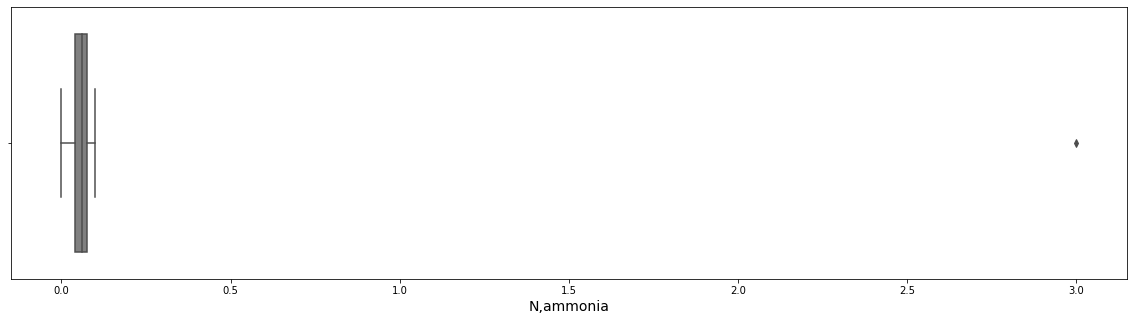

Watertemp :


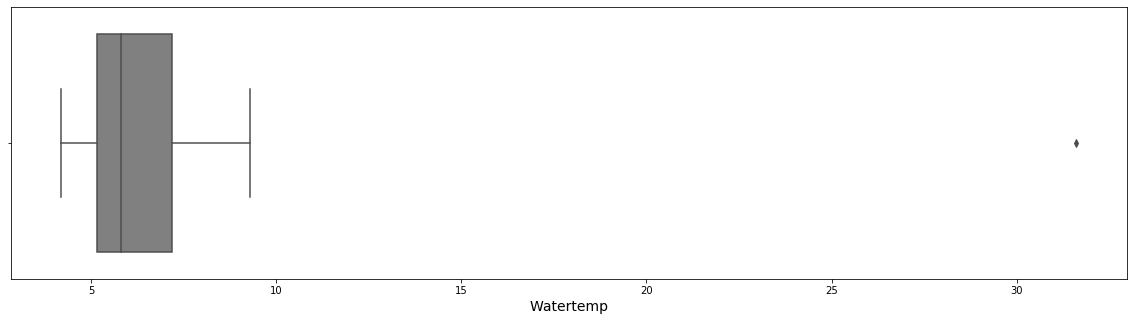

In [19]:
check_zscore(df_test, should_be_numeric)

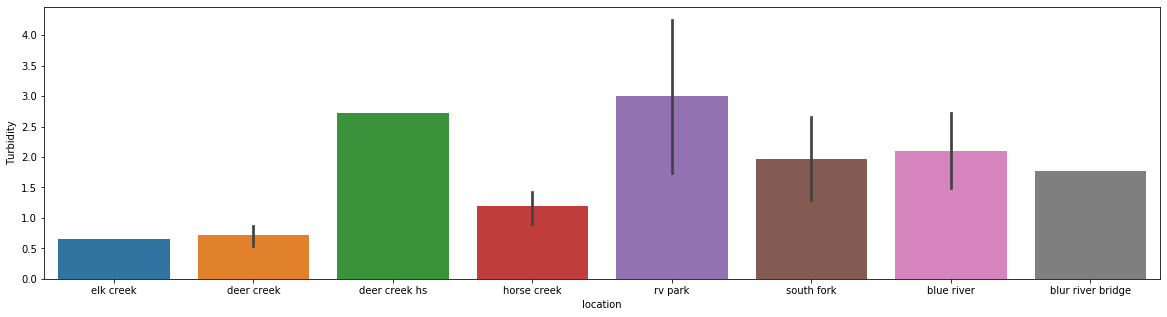

In [20]:
# simple plot
plt.figure(figsize=(20,5))
sns.barplot(x='location',y='Turbidity',data=df_total)